# TAAK Data Prasentation: Zonne-energie op basis van het weer
In dit datavisualisatie project wordt de correlatie tussen de productie van elektrischiteit met zonnepanelen en het weer op dat moment onderzocht. Op het einde wordt er een conclusie getrokken waarin dit zal worden aangetoond of weerlegd. Er wordt met Spark (PySpark) gewerkt in een Jupyter Notebook om de data te preprocessen en te analyseren.

De data is beperkt tot Canada gezien ik geen andere kwalitatieve data kon vinden waar ook kwalitatieve historische weerdata voor te vinden was.

De datasets zijn terug te vinden op onderstaande links.
- weer data: https://calgary.weatherstats.ca/download.html
https://climatedata.ca/download/

b optie data voor dit project: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data
- solar production: https://www.kaggle.com/datasets/ivnlee/solar-energy-production

## Imports en spark innitialiseren

In [8]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, to_date
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

In [9]:
spark = SparkSession.builder.master("local").appName("DataPresentationTaak").getOrCreate()

In [10]:
spark

## 1 Data inladen

In [11]:
data_energy = "../SolarEnergyData/Solar_Energy_Production.csv"
data_weather = "../SolarEnergyData/weatherstats_calgary_dailySince2015.csv"

df_energy = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load(data_energy)
df_weather = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load(data_weather)

## 2 Data exploratory 

In [12]:
df_energy.show()

+--------------------+------+-------------+--------------------+------+--------------------+----------------+--------------------+
|                name|    id|      address|                date|   kWh|          public_url|installationDate|                 uid|
+--------------------+------+-------------+--------------------+------+--------------------+----------------+--------------------+
|Calgary Fire Hall...|314106|1212 42 AV SE|2017/09/11 08:00:...|  1.13|https://monitorin...|      2016/11/07|3141062017-09-11 ...|
|Calgary Fire Hall...|314106|1212 42 AV SE|2017/09/11 09:00:...|  2.34|https://monitorin...|      2016/11/07|3141062017-09-11 ...|
|Calgary Fire Hall...|314106|1212 42 AV SE|2017/09/11 10:00:...| 3.656|https://monitorin...|      2016/11/07|3141062017-09-11 ...|
|Calgary Fire Hall...|314106|1212 42 AV SE|2017/09/11 11:00:...| 4.577|https://monitorin...|      2016/11/07|3141062017-09-11 ...|
|Calgary Fire Hall...|314106|1212 42 AV SE|2017/09/11 12:00:...| 6.506|https://moni

In [13]:
df_energy.count()

258423

In [14]:
df_weather.count()

10000

De energie-productie (df_energy_df) dataset bevat 258423 records en de weer-dataset (df_weather) bevat er 10000. Bij 'df_energy' gaan we algemener kijken en groeperen per dag, omdat er helaas geen data per uur terug te vinden was over deze periode. Bij 'df_weather' vallen er nog een heel deel records af die buiten het bereik van 'df_energy' liggen. Zie Cleaning stap 3

### checken op nullwaardes (missing data)

In [15]:
null_columns_e = []

for column in df_energy.columns:
    if df_energy.filter(col(column).isNull()).count() > 0:
        null_columns_e.append(column)

if len(null_columns_e) == 0:
    print("dataset bevat geen kolommen met nullwaardes!")
else:
    print("dataset bevat kolommen met nullwaardes, namelijk de kolommen:\n")
    for column_name in null_columns:
        print(column_name)

dataset bevat geen kolommen met nullwaardes!


In [16]:
null_columns_w = []

for column in df_weather.columns:
    if df_weather.filter(col(column).isNull()).count() > 0:
        null_columns_w.append(column)
        
if len(null_columns_w) == 0:
    print("dataset bevat geen kolommen met nullwaardes!")
else:
    print("dataset bevat kolommen met nullwaardes, namelijk de kolommen:\n")
    for column_name in null_columns_w:
          print(column_name)

dataset bevat kolommen met nullwaardes, namelijk de kolommen:

max_humidex
min_windchill
max_wind_gust
wind_gust_dir_10s
max_health_index
avg_hourly_health_index
avg_health_index
min_health_index
precipitation
rain
snow
snow_on_ground
sunrise_hhmm
sunrise_unixtime
sunrise_f
sunset_hhmm
sunset_unixtime
sunset_f
daylight
min_uv_forecast
max_uv_forecast
min_high_temperature_forecast
max_high_temperature_forecast
min_low_temperature_forecast
max_low_temperature_forecast
solar_radiation
max_cloud_cover_4
avg_hourly_cloud_cover_4
avg_cloud_cover_4
min_cloud_cover_4
max_cloud_cover_8
avg_hourly_cloud_cover_8
avg_cloud_cover_8
min_cloud_cover_8
max_cloud_cover_10
avg_hourly_cloud_cover_10
avg_cloud_cover_10
min_cloud_cover_10


Gelukkig zijn dit geen kolommen die we later nodig hebben dus vormt het niet meteen een probleem. 

### verdeling temperatuur

In [22]:
# ik heb het uiteindelijkj met .ToPandas() gedaan om te plotten want ik kreeg een "python mismatching 3.9 3.11" error 
# bij df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect() 

"""
column_data = df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(column_data, bins=20, color='blue', edgecolor='black', alpha=0.7)

# Formatting
plt.title('Histogram of Column Name')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#----


from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, df_weather.select('avg_temperature'), bins = 20, color=['red'])
"""

# error Python in worker has different version (3, 11) than that in driver 3.9, PySpark cannot run with different minor versions.
# Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

"\ncolumn_data = df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect()\n\n# Plotting the histogram\nplt.figure(figsize=(10, 6))\nplt.hist(column_data, bins=20, color='blue', edgecolor='black', alpha=0.7)\n\n# Formatting\nplt.title('Histogram of Column Name')\nplt.xlabel('Values')\nplt.ylabel('Frequency')\nplt.grid(True)\nplt.show()\n\n\n#----\n\n\nfrom pyspark_dist_explore import hist\nimport matplotlib.pyplot as plt\n\nfig, ax = plt.subplots()\nhist(ax, df_weather.select('avg_temperature'), bins = 20, color=['red'])\n"

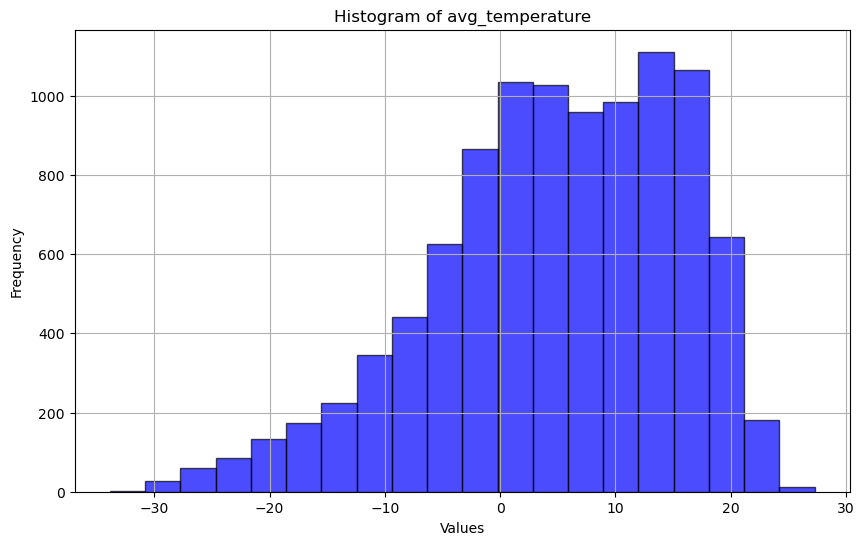

In [20]:
column_data = df_weather.select('avg_temperature').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(column_data['avg_temperature'], bins=20, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of avg_temperature')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

TODO # uitleg histogram...

### verdeling opwekking zonne-energie

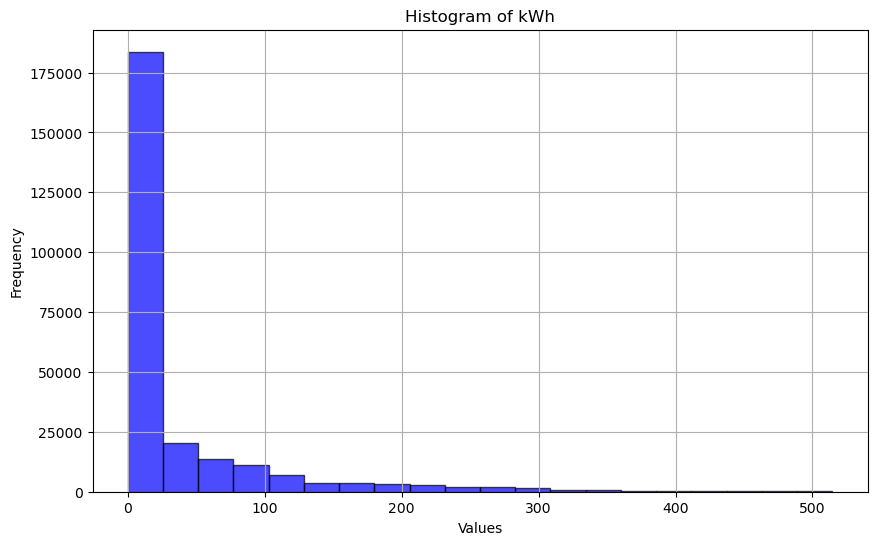

In [21]:
column_data = df_energy.select('kWh').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(column_data['kWh'], bins=20, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of kWh')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

TODO # uitleg histogram...

In [16]:
# MSS NIET NODIG EN LATER STRUCTUUR IN DATA CREEREN !!! 
"""
schema = StructType([
    StructField("col1", IntegerType(0), True),
    StructField("col2", IntegerType(0), True),
    StructField("col3", IntegerType(0), True),
    StructField("col4", IntegerType(0), True),
    StructField("col5", IntegerType(0), True),
    StructField("col6", IntegerType(0), True),
    StructField("col7", IntegerType(0), True),
    StructField("col8", IntegerType(0), True),
    
])
"""

'\nschema = StructType([\n    StructField("col1", IntegerType(0), True),\n    StructField("col2", IntegerType(0), True),\n    StructField("col3", IntegerType(0), True),\n    StructField("col4", IntegerType(0), True),\n    StructField("col5", IntegerType(0), True),\n    StructField("col6", IntegerType(0), True),\n    StructField("col7", IntegerType(0), True),\n    StructField("col8", IntegerType(0), True),\n    \n])\n'

In [17]:
#tests en backup code
"""
df_energy = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load("../input/airbnbopendata/Airbnb_Open_Data.csv")

# csv inladen
energy = spark.read.format("csv").schema(schema).option(data_energy, "test.csv").load()
weather = spark.read.format("csv").schema(schema).option("path", "test.csv").load()
"""

'\ndf_energy = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load("../input/airbnbopendata/Airbnb_Open_Data.csv")\n\n# csv inladen\nenergy = spark.read.format("csv").schema(schema).option(data_energy, "test.csv").load()\nweather = spark.read.format("csv").schema(schema).option("path", "test.csv").load()\n'

In [18]:
# df_weather.select("Date").orderBy(col("date").asc()).show()

## 3 cleaning & preprocessing

### date kolom aanpassen

In [19]:
df_energy.select("date").orderBy("date").show()

+--------------------+
|                date|
+--------------------+
|2015/09/01 02:30:...|
|2015/09/01 03:30:...|
|2015/09/01 04:30:...|
|2015/09/01 05:30:...|
|2015/09/01 06:30:...|
|2015/09/01 07:30:...|
|2015/09/01 08:30:...|
|2015/09/01 09:30:...|
|2015/09/01 10:30:...|
|2015/09/01 11:30:...|
|2015/09/02 01:30:...|
|2015/09/02 01:30:...|
|2015/09/02 02:30:...|
|2015/09/02 02:30:...|
|2015/09/02 03:30:...|
|2015/09/02 04:30:...|
|2015/09/02 05:30:...|
|2015/09/02 06:30:...|
|2015/09/02 06:30:...|
|2015/09/02 07:30:...|
+--------------------+
only showing top 20 rows



df_energy datums nog omzetten (casten) naar een date want staat oorspronkelijk in het unixtime formaat met `yyyy/MM/dd hh:mm:ss a`en er moet iets van het type date `yyyy/MM/dd` bekomen worden zoals we in de df_weather hebben. Zo kan de data later worden samengevoegd op basis van gelijke datums.

In [20]:
df_energy = df_energy.withColumn("date2", from_unixtime(unix_timestamp(col("date"), 'yyyy/MM/dd hh:mm:ss a')).cast("date"))

df_energy.select("date2").show()

+----------+
|     date2|
+----------+
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
+----------+
only showing top 20 rows



### data uit df_energy groeperen per dag
Er wordt verder gerekend met de gemiddelde kWh per dag in df_energy, gezien we niet van elk uur weerdata ter beschikking hebben.
Zoals we ook al bij het inladen konden zien bevat df_energy 258423 rijen (omdat er meerdere metingen zijn per dag) en df_weather 10000 rijen, per dag 1 record.

In [21]:
df_energy = df_energy.withColumn("date2", from_unixtime(unix_timestamp(col("date"), 'yyyy/MM/dd hh:mm:ss a')).cast("date"))
# groepeer per dag en bereken average temperature per dag
df_energy_day = df_energy.groupBy("date2").agg({"kWh": "avg"}).orderBy("date2")#.show() returnt een NoneType, hierdoor kan er later nioet mee gewerkt worden! 

df_energy_day.show()

+----------+------------------+
|     date2|          avg(kWh)|
+----------+------------------+
|2015-09-01|28.601300000000002|
|2015-09-02| 32.45933333333333|
|2015-09-03|30.852666666666657|
|2015-09-04|            5.1224|
|2015-09-05|4.9174736842105276|
|2015-09-06|           18.3813|
|2015-09-07|30.262947368421052|
|2015-09-08|           24.4907|
|2015-09-09|           36.6001|
|2015-09-10|  33.0881052631579|
|2015-09-11| 45.54736842105263|
|2015-09-12| 44.59063157894737|
|2015-09-13|13.285210526315788|
|2015-09-14|  5.36278947368421|
|2015-09-15| 32.56542105263158|
|2015-09-16| 35.77613333333333|
|2015-09-17| 50.94357142857143|
|2015-09-18| 50.00066666666666|
|2015-09-21| 45.08325000000001|
|2015-09-22|60.640538461538455|
+----------+------------------+
only showing top 20 rows



In [22]:
#df_energy_day.count()

### data buiten bereik filteren
Dagen uit df_weather verwijderen die buiten het bereik van df_energy vallen.


In [23]:
# temp table
df_weather.createOrReplaceTempView("weather_table")
df_energy_day.createOrReplaceTempView("energy_table")

#SQL queries
query_w = """
    SELECT
        MIN(CAST(date AS DATE)) AS min_date,
        MAX(CAST(date AS DATE)) AS max_date
    FROM
        weather_table
"""

query_e = """
    SELECT
        MIN(CAST(date2 AS DATE)) AS min_date,
        MAX(CAST(date2 AS DATE)) AS max_date
    FROM
        energy_table
"""

# Execute SQL
date_min_max_w = spark.sql(query_w).first()
date_min_max_e = spark.sql(query_e).first()

min_date_w = date_min_max_w.min_date
max_date_w = date_min_max_w.max_date
min_date_e = date_min_max_e.min_date
max_date_e = date_min_max_e.max_date

records_df_energy = df_energy_day.count()
records_df_weather = df_weather.count()

print(f"Minimum datum uit df_weather is: {min_date_w}")
print(f"Maximum datum uit df_weather is: {max_date_w}")
print(f"Minimum datum uit df_energy_day is: {min_date_e}")
print(f"Maximum datum uit df_energy_day is: {max_date_e}")
print(f"\nAantal overgebleven records uit df_energy na groepering per dag is: {records_df_energy}")
print(f"Aantal records uit df_weather is: {records_df_weather}")

Minimum datum uit df_weather is: 1996-07-13
Maximum datum uit df_weather is: 2023-11-28
Minimum datum uit df_energy_day is: 2015-09-01
Maximum datum uit df_energy_day is: 2023-03-16

Aantal overgebleven records uit df_energy na groepering per dag is: 2716
Aantal records uit df_weather is: 10000


Nu zijn er meer 'weather' records dan 'energy' records en moet de data buiten het bereik van van de dagen waarvoor er energie-data is, uitgefilterd worden.

Er hoeft niet speciaal nog een drop operatie gedaan worden om de data te verwijderen die niet matcht aangezien er later nog gejoind zal worden en de data die overeenkomt automatisch overgehouden wordt

### niet-relevante kolommen uitfilteren

Voor dit project zijn we enkel geinteresseerd in de `avg_temperature` kolom uit `df_weather`. Natuurlijk zijn er heel wat andere kolommen die ook invloed hebben op de energieproductie van zonnepanelen maar we willen juist de correlatie bespreken tussen een warme dag of een koude dag en de daarbij horende energie opwekking.

er zijn een paar kolommen kandidaat: TODO nog uitzoeken welke!!!! ####
- avg_cloud_cover_4
- avg_cloud_cover_8
- avg_cloud_cover_10

In [24]:
df_weather.describe()

DataFrame[summary: string, max_temperature: string, avg_hourly_temperature: string, avg_temperature: string, min_temperature: string, max_humidex: string, min_windchill: string, max_relative_humidity: string, avg_hourly_relative_humidity: string, avg_relative_humidity: string, min_relative_humidity: string, max_dew_point: string, avg_hourly_dew_point: string, avg_dew_point: string, min_dew_point: string, max_wind_speed: string, avg_hourly_wind_speed: string, avg_wind_speed: string, min_wind_speed: string, max_wind_gust: string, wind_gust_dir_10s: string, max_pressure_sea: string, avg_hourly_pressure_sea: string, avg_pressure_sea: string, min_pressure_sea: string, max_pressure_station: string, avg_hourly_pressure_station: string, avg_pressure_station: string, min_pressure_station: string, max_visibility: string, avg_hourly_visibility: string, avg_visibility: string, min_visibility: string, max_health_index: string, avg_hourly_health_index: string, avg_health_index: string, min_health_in

In [25]:
#kolommen die we niet nodig hebben uitfilteren

In [26]:
df_weather_selected_col = df_weather.select("date", "avg_temperature")

### joinen op basis van datum

In [27]:
# Alias
energy = df_energy_day.alias("df_energy_day")
weer = df_weather_selected_col.alias("df_weather")

# inner join on 'date' kolom
joined_df = energy.join(weer, energy['date2'] == weer['Date'], 'left')

joined_df.select(energy['date2'], energy['avg(kWh)'], weer['avg_temperature']).orderBy("date2").show()

+----------+------------------+---------------+
|     date2|          avg(kWh)|avg_temperature|
+----------+------------------+---------------+
|2015-09-01|28.601300000000002|          14.64|
|2015-09-02| 32.45933333333333|          15.45|
|2015-09-03|30.852666666666657|           9.19|
|2015-09-04|            5.1224|           5.69|
|2015-09-05|4.9174736842105276|            3.7|
|2015-09-06|           18.3813|            5.0|
|2015-09-07|30.262947368421052|           9.94|
|2015-09-08|           24.4907|           10.8|
|2015-09-09|           36.6001|           13.3|
|2015-09-10|  33.0881052631579|           12.1|
|2015-09-11| 45.54736842105263|           16.8|
|2015-09-12| 44.59063157894737|          19.14|
|2015-09-13|13.285210526315788|          10.15|
|2015-09-14|  5.36278947368421|            5.9|
|2015-09-15| 32.56542105263158|           8.55|
|2015-09-16| 35.77613333333333|            7.0|
|2015-09-17| 50.94357142857143|           8.15|
|2015-09-18| 50.00066666666666|         

In [28]:
# we hebben nu 2 datum kolommen dus 1tje mag verwijderd worden
joined_df = joined_df.drop(col("date2"))

In [29]:
joined_df.count()

2716

In [30]:
joined_df.show()

+------------------+----------+---------------+
|          avg(kWh)|      date|avg_temperature|
+------------------+----------+---------------+
|34.126020833333335|2017-09-11|          18.64|
| 61.16932075471698|2017-08-11|           18.7|
| 42.58591666666667|2016-03-01|          -0.59|
|61.045993464052316|2019-06-04|           16.0|
|           66.2803|2018-05-28|           20.0|
| 54.34225641025642|2018-08-10|          26.15|
| 53.71429411764706|2021-06-22|           21.6|
| 48.74009210526314|2019-05-08|           7.25|
|37.910468468468466|2021-10-11|           0.95|
|62.834886666666655|2020-08-24|          20.25|
|1.8028571428571432|2021-12-18|          -9.19|
| 23.22218681318681|2021-11-13|           3.45|
| 3.548602564102563|2021-01-27|          -13.2|
|  32.0981971830986|2021-08-27|          15.45|
| 34.12024615384616|2022-03-28|           0.59|
|53.465215277777766|2022-07-31|          21.65|
|14.803142857142856|2016-04-25|            3.8|
|27.433728260869565|2019-11-18|         

### datatypes toekennen

In [31]:
column_data_types = joined_df.dtypes

for column, data_type in column_data_types:
    print(f"Column: {column}, Data Type: {data_type}")

Column: avg(kWh), Data Type: double
Column: date, Data Type: date
Column: avg_temperature, Data Type: double


Zo te zien bevat deze dataframe al automatisch de juiste datatypes om mee aan de slag te gaan. 

## Visualisatie

TODO ####  mooie grafiek met plot en VERWACHT.... winter zomer duidelijk aflezen
evt met widgets,...

In [ ]:
### TODO: checken of dagen uniek zijn!!!!!!

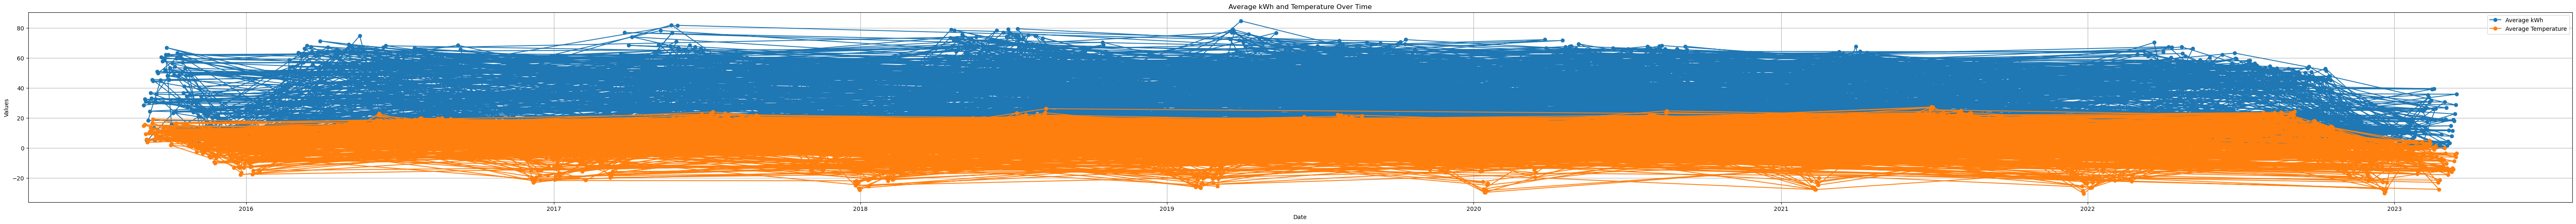

In [54]:
#plot
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col

df_plot = joined_df.groupBy(year('date').alias('year'), month('date').alias('month')).agg({'avg(kWh)': 'avg', 'avg_temperature': 'avg'})

dates = [row['date'] for row in df_plot.collect()]
avg_kWh_values = [row['avg(kWh)'] for row in df_plot.collect()]
avg_temperature_values = [row['avg_temperature'] for row in df_plot.collect()]

plt.figure(figsize=(80, 6))
plt.plot(dates, avg_kWh_values, label='Average kWh', marker='o')
plt.plot(dates, avg_temperature_values, label='Average Temperature', marker='o')

plt.title('Average kWh and Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

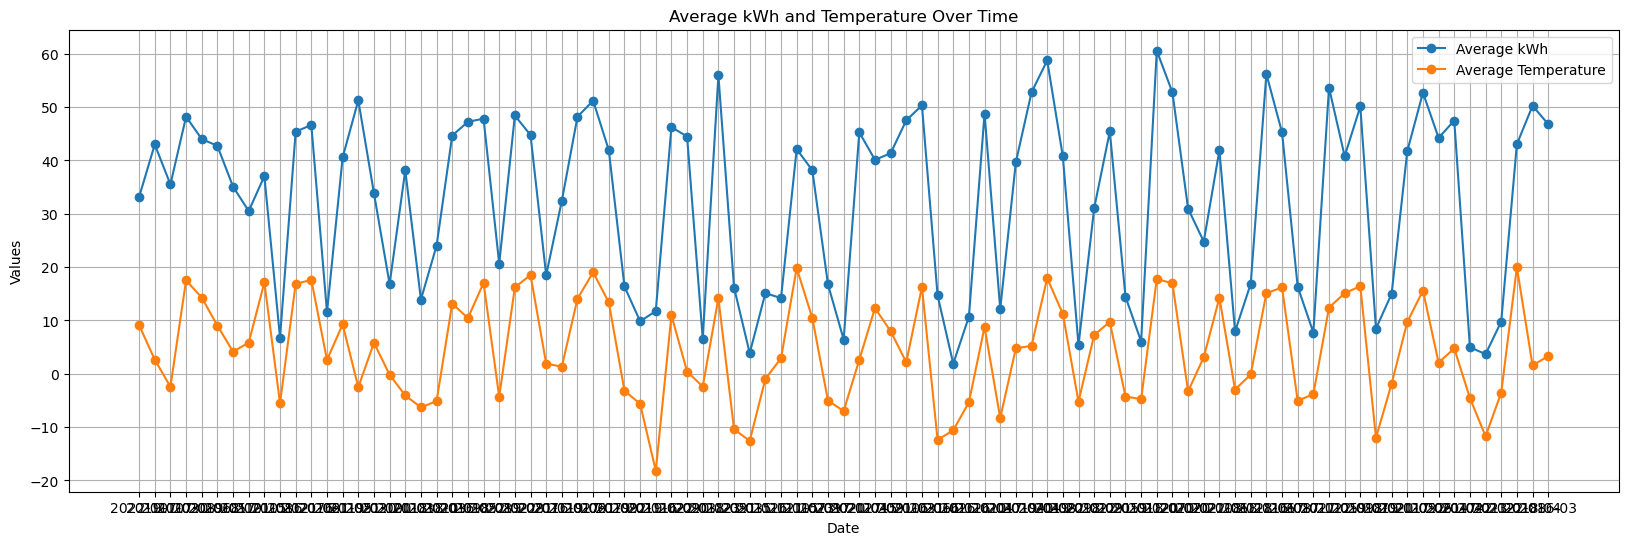

In [53]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month


# Group data by year or month and calculate the average
df_plot = joined_df.groupBy(year('date').alias('year'), month('date').alias('month')).agg({'avg(kWh)': 'avg', 'avg_temperature': 'avg'})

# Extract data for plotting
dates = [f"{row.year}-{row.month:02d}" for row in df_plot.collect()]
avg_kWh_values = [row['avg(avg(kWh))'] for row in df_plot.collect()]
avg_temperature_values = [row['avg(avg_temperature)'] for row in df_plot.collect()]

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(dates, avg_kWh_values, label='Average kWh', marker='o')
plt.plot(dates, avg_temperature_values, label='Average Temperature', marker='o')

# Formatting
plt.title('Average kWh and Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#widget per jaar/month vanaf wanner,..
#https://ipywidgets.readthedocs.io/en/stable/

In [58]:
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider(value=7, continuous_update=False, description='Test:', max=10)

In [60]:
widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', max=10.0, readout_format='.1f…

In [59]:
w = widgets.IntSlider()

w.value = 100




display(w)



IntSlider(value=100)

In [61]:
widgets.Checkbox(
    value=False,
    description='Check me',
    disabled=False,
    indent=False
)


Checkbox(value=False, description='Check me', indent=False)

In [62]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

In [63]:
widgets.Dropdown(
    options=[('One', 1), ('Two', 2), ('Three', 3)],
    value=2,
    description='Number:',
)

Dropdown(description='Number:', index=1, options=(('One', 1), ('Two', 2), ('Three', 3)), value=2)

In [64]:
widgets.RadioButtons(
    options=['pepperoni', 'pineapple', 'anchovies'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Pizza topping:',
    disabled=False
)

RadioButtons(description='Pizza topping:', options=('pepperoni', 'pineapple', 'anchovies'), value='pepperoni')

In [65]:
widgets.Select(
    options=['Linux', 'Windows', 'macOS'],
    value='macOS',
    # rows=10,
    description='OS:',
    disabled=False
)

Select(description='OS:', index=2, options=('Linux', 'Windows', 'macOS'), value='macOS')

In [67]:
widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False
)

SelectMultiple(description='Fruits', index=(1,), options=('Apples', 'Oranges', 'Pears'), value=('Oranges',))

In [66]:
import datetime
dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
options = [(i.strftime('%b'), i) for i in dates]
widgets.SelectionRangeSlider(
    options=options,
    index=(0, 11),
    description='Months (2015)',
    disabled=False
)

SelectionRangeSlider(description='Months (2015)', index=(0, 11), options=(('Jan', datetime.date(2015, 1, 1)), …

In [68]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

DatePicker(value=None, description='Pick a Date')

In [69]:
items = [widgets.Label(str(i)) for i in range(8)]
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))

GridBox(children=(Label(value='0'), Label(value='1'), Label(value='2'), Label(value='3'), Label(value='4'), La…

In [37]:
correlation_value = joined_df.stat.corr("avg(kWh)", "avg_temperature")

print(f"Correlatie tussen average Kwh en de temperatuur is: {correlation_value}")

Correlatie tussen average Kwh en de temperatuur is: 0.6772647080391323


Men kan hier dus spreken van een redelijk sterke correlatie tussen de temperatuur en de hoeveelheid energie die opgewekt wordt. Als de temperatuur verhoogt verhoogt dus ook de hoeveelheid kWh die opgewekt wordt.

In [43]:
### kan alleen matrix printen als er meerder kolommen zijn (dat je een dataframe terug krijgt, met 2 kolommen krijg je gwn een float terug)
"""
correlation_matrix = joined_df.stat.corr("avg(kWh)", "","","", "avg_temperature")

print("Correlation Matrix:")
correlation_matrix.show()
"""

'\ncorrelation_matrix = joined_df.stat.corr("avg(kWh)", "","","", "avg_temperature")\n\nprint("Correlation Matrix:")\ncorrelation_matrix.show()\n'

In [42]:
# plot

## Conclusie

Andere kolommen waarvan de productie zeker afhaneklijk is: 

----
max visibility
preciptation/rain/snow en vooral snow_on_ground
solar_radiation
sunrise-sunset
daylight